## QUESTION 1

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import pyarrow
import fastparquet
import pickle
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
df = pd.read_parquet('https://data434.s3.us-east-2.amazonaws.com/Phishing_Email.parquet')
df.head()

,index,Unnamed: 0,Email Text,Email Type
0,0,0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email
1,1,1,the other side of * galicismos * * galicismo *...,Safe Email
2,2,2,re : equistar deal tickets are you still avail...,Safe Email
3,3,3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email
4,4,4,software at incredibly low prices ( 86 % lower...,Phishing Email


In [3]:
df['tokens'] = df['Email Text'].apply(lambda text: text.split())
print(df[['Email Text', 'tokens']].head())

                                          Email Text  \
0  re : 6 . 1100 , disc : uniformitarianism , re ...   
1  the other side of * galicismos * * galicismo *...   
2  re : equistar deal tickets are you still avail...   
3  \nHello I am your hot lil horny toy.\n    I am...   
4  software at incredibly low prices ( 86 % lower...   

                                              tokens  
0  [re, :, 6, ., 1100, ,, disc, :, uniformitarian...  
1  [the, other, side, of, *, galicismos, *, *, ga...  
2  [re, :, equistar, deal, tickets, are, you, sti...  
3  [Hello, I, am, your, hot, lil, horny, toy., I,...  
4  [software, at, incredibly, low, prices, (, 86,...  


### To clean the tokens for language processing, I would first strip commas, astrixes, and similar symbols from the text. I would then analyze types of words that appear to be associated with phishing (ex: sexual content). I would also look at emails with repeating words, as repetitive language seems to indicate phishing. Subsequently, I might try to find correlations between these variables before running a predictive classification model using an 80/20 testing/training split.

# QUESTION 2

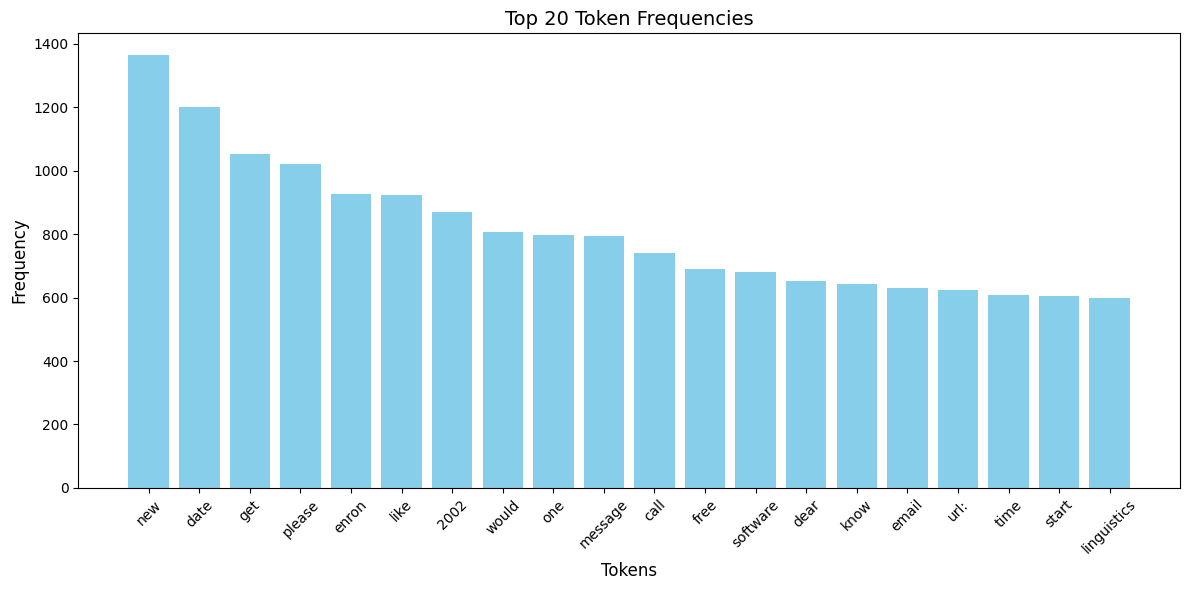

In [4]:
with open('/workspace/PCA/05_PCA/all_tokens.pickle', 'rb') as file:
    all_tokens = pickle.load(file)

token_count = Counter(all_tokens)
token_freq = token_count.most_common()
tokens, counts = zip(*token_freq)


tokens, counts = zip(*token_freq)

# Plot the histogram
plt.figure(figsize=(12, 6))  # Set the figure size
plt.bar(tokens[:20], counts[:20], color='skyblue')  # Show the top 20 tokens for readability
plt.xlabel('Tokens', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Top 20 Token Frequencies', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust layout to fit labels
plt.show()  # Display the plot


### This histogram reveals some interesting data. I'm surprised that the word "linguistics" is the 20th most used word in this set of phishing emails. Tech-related buzzwords such as software, email, url, and message tend to be very common, which makes sense.

# QUESTION 3

In [ ]:
from sklearn.model_selection import train_test_split

file_path = '/workspace/PCA/05_PCA/Phishing_clean.parquet'
df = pd.read_parquet(file_path)

X = df.drop(columns=['Email Type'])
y = df['Email Type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# code generated using chat gpt:

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Initialize the logistic regression model
model = LogisticRegression(max_iter=1000)

# Fit the model on the training data
model.fit(X_train, y_train)

# Make predictions on both the training and test sets
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Evaluate performance
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Training accuracy: {train_accuracy}")
print(f"Test accuracy: {test_accuracy}")

# Optional: Get classification report for more detailed performance metrics
print("Classification report (Test set):")
print(classification_report(y_test, y_test_pred))


Training accuracy: 0.9666599584088013
Test accuracy: 0.941239602897773
Classification report (Test set):
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      2209
           1       0.91      0.95      0.93      1518

    accuracy                           0.94      3727
   macro avg       0.94      0.94      0.94      3727
weighted avg       0.94      0.94      0.94      3727



In [7]:
# code generated using chat gpt:

# Get the feature names (tokens)
tokens = X.columns

# Get the model's coefficients
coefficients = model.coef_[0]

# Create a DataFrame of words and their corresponding coefficients
coef_df = pd.DataFrame({'word': tokens, 'coefficient': coefficients})

# Sort by absolute coefficient value (most influential words)
coef_df['abs_coefficient'] = coef_df['coefficient'].abs()
coef_df_sorted = coef_df.sort_values(by='abs_coefficient', ascending=False)

# Display the top 10 most influential words (with largest coefficients)
print("Top 10 most influential words based on coefficients:")
print(coef_df_sorted[['word', 'coefficient']].head(10))


Top 10 most influential words based on coefficients:
          word  coefficient
4        enron    -4.308871
16        url:    -4.144157
35       vince    -3.083769
22      wrote:    -3.058260
88      louise    -2.956818
168  forwarded    -2.571457
25    language    -2.500870
103      wrote    -2.471931
205      daren    -2.410629
818       cnet    -2.268266


# QUESTION 4

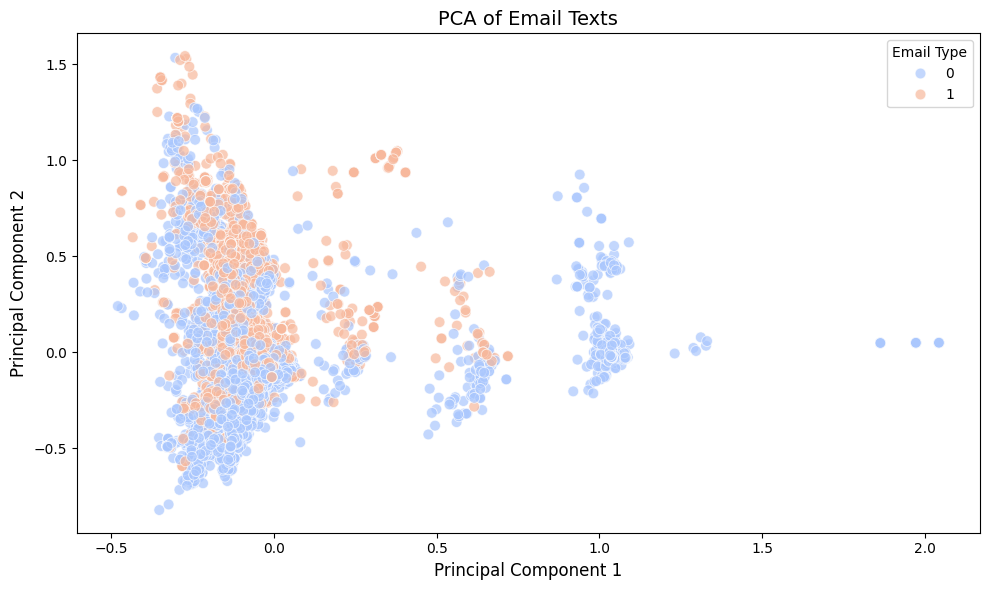

In [ ]:
# code generated with help from chat gpt

from sklearn.decomposition import PCA

# Load the dataset (assuming you've already loaded df as shown earlier)
file_path = '/workspace/PCA/05_PCA/Phishing_clean.parquet'
df = pd.read_parquet(file_path)

# Separate the features (excluding Email Type) and target variable
X = df.drop(columns=['Email Type'])  # One-hot-encoded tokens (features)
y = df['Email Type']  # Email Type is the target variable

# Perform PCA to reduce to two components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Create a DataFrame with the PCA components and the target variable for hue
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['Email Type'] = y  # Add the target variable for coloring the points

# Plot the first two principal components, with hue based on the Email Type
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Email Type', palette='coolwarm', s=60, alpha=0.7)

# Add labels and title
plt.title('PCA of Email Texts', fontsize=14)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()


### The points on this graph are somewhat intermixed, indicating that the PCA model will likely be unable to predict phishing with full accuracy using PC1 and PC2. However, it seems that emails with higher levels of PC1 tend to be non-phishing emails. 

# QUESTION 5

In [ ]:
# code generated using chat gpt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Separate the features (X) and target variable (y)
X = df.drop(columns=['Email Type'])  # One-hot-encoded tokens (features)
y = df['Email Type']  # Email Type is the target variable

# Perform PCA to reduce to 2,610 components
pca = PCA(n_components=2610)
X_pca = pca.fit_transform(X)

# Split the data into training and test sets (80/20)
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Initialize and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on both the training and test sets
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Evaluate the performance
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

print(f"Training R²: {train_r2}")
print(f"Test R²: {test_r2}")
print(f"Training MSE: {train_mse}")
print(f"Test MSE: {test_mse}")


Training R²: 0.7662354580368252
Test R²: 0.668441786659995
Training MSE: 0.05554410779292842
Test MSE: 0.08004026035156273


In [ ]:
# code egenerated using chat gpt

# Perform train-test split on the original data (without PCA)
X_train_original, X_test_original, y_train_original, y_test_original = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the linear regression model on the original data
model_original = LinearRegression()
model_original.fit(X_train_original, y_train_original)

# Make predictions on both the training and test sets
y_train_original_pred = model_original.predict(X_train_original)
y_test_original_pred = model_original.predict(X_test_original)

# Evaluate the performance on the original data
train_r2_original = r2_score(y_train_original, y_train_original_pred)
test_r2_original = r2_score(y_test_original, y_test_original_pred)
train_mse_original = mean_squared_error(y_train_original, y_train_original_pred)
test_mse_original = mean_squared_error(y_test_original, y_test_original_pred)

print(f"Training R² (Original Data): {train_r2_original}")
print(f"Test R² (Original Data): {test_r2_original}")
print(f"Training MSE (Original Data): {train_mse_original}")
print(f"Test MSE (Original Data): {test_mse_original}")


Training R² (Original Data): 0.7665728265932069
Test R² (Original Data): -2.6354020553782844e+22
Training MSE (Original Data): 0.055463946638870415
Test MSE (Original Data): 6.362028089082784e+21


### The PCA method yields a higher test R^2 value of 0.668, vs the linear regression test R^2 value of -2.64.

# QUESTION 6

### The tokens we're looking at contain a wide range of variability, as well as potential noise (i.e: tokens that occur infrequently / aren't useful in prediction). Therefore, applying the PCA method can help to reduce overfitting and overgeneralizing.